In [1]:
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

### GPT 모델 구현

In [2]:
"""PositionalEncoding -> EmbeddingLayer

token 임베딩과 positional 임베딩을 함께 진행하는 층 구현

"""

class EmbeddingLayer(tf.keras.layers.Layer):
    def  __init__(self, vocab_size, d_model, max_position):
        """
        Args:
            vocab_size: 토큰 수
            d_model: 임베딩 차원
            max_position: 최대 시퀀스 길이
        """
        super(EmbeddingLayer, self).__init__()
        ## 토큰 임베딩
        self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=d_model
        )
        ## 포지셔널 임베딩
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=max_position, 
            output_dim=d_model
        )
    
    def call(self, x):
        ## token embedding
        token_embeddings = self.token_embedding(x)
        
        ## positional embedding
        seq_length = tf.shape(x)[1] # 시퀀스 길이
        positions = tf.range(start=0, limit=seq_length, delta=1) # 토큰 위치 데이터 형성
        positions = tf.expand_dims(positions, axis=0) # 배치 단위로 누적해서 차원 늘리기
        
        positional_embeddings = self.position_embedding(positions)
        
        return token_embeddings, positional_embeddings

In [3]:
## 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    ## 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    ## 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    ## 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    ## softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    ## 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output

In [4]:
## MultiHeadAttention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads ## multi heads 수
        self.d_model = d_model ## embedding layer 수

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)  
        key = self.key_dense(key)        
        value = self.value_dense(value)  

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)      
        value = self.split_heads(value, batch_size) 

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [5]:
## Padding Masking
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

## Look-ahead masking
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

In [6]:
"""encoder & encoder layer
  
인코더는 gpt에서 사용하지 않으므로 제거합니다.   

"""  

'encoder & encoder layer\n  \n인코더는 gpt에서 사용하지 않으므로 제거합니다.   \n\n'

In [7]:
"""decoder layer

인코더-디코더 어텐션 층을 사용하지 않으므로 제거합니다. 

또한 masked multi-head self-attention에서의 결과 값을 잔차연결한 후 층 정규화를 진행합니다. 
이후의 결과 값을 바로 dense 층에 연결합니다. 
dense 층의 결과를 다시 잔차연결해주고 층 정규화를 진행합니다. 

"""

## 디코더 하나의 레이어를 함수로 구현.
## 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    ## Look ahead mask 사용
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")

    ## 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    ## 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs) ## 잔차연결

    ##### 변경사항: 어텐션1로 바로 연결. #####
    ## 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    ## 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [95]:
"""decoder

인코더로부터의 입력을 받는 부분을 제거합니다. 
포지셔널 인코딩을 포지셔널 임베딩으로 변경합니다. 

"""
## Decoder
def decoder(vocab_size,
            max_position, 
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    ## look ahead mask 사용
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
  
    ## 토큰 임베딩 레이어 & 포지셔널 임베딩 레이어
    token_embeddings, positional_embeddings = EmbeddingLayer(vocab_size, d_model, max_position)(inputs)
    embeddings = token_embeddings + positional_embeddings
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    ## Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask])
        
    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

## Step 1. 데이터 수집하기

In [9]:
data = pd.read_csv("~/data/ChatbotData .csv")
data = data[["Q", "A"]]
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [10]:
print("총 데이터 수 :", len(data))

총 데이터 수 : 11823


In [11]:
## 결측치 확인
data.isna().sum()

Q    0
A    0
dtype: int64

In [12]:
## 중복값 확인
data[data.duplicated()]

,Q,A
5527,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.
5537,고백하고 후회하면 어떡하지,후회는 후회를 낳을뿐이에요. 용기 내세요.
5542,공부는 내 체질이 아닌 것 같아,확신이 없나봐요.
5704,기숙사 괜찮을까,혼자 사는 것보다 불편하겠죠.
5774,나는 좋은데 ….,현실의 벽에 부딪혔나봐요.
...,...,...
8764,환승 가능?,환승은 30분 안에
8780,회사 사람들이 아직도 불편해,회사에는 동료가 있을 뿐이에요.
8782,회사에는 왜 친구 같은 사람이 없을까,회사는 친구 사귀는 곳이 아니에요.
8789,후련하달까,후련하니 다행이에요.


## Step 2. 데이터 전처리하기

In [13]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence의 영어는 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower()
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, 0-9, ".", "?", "!", ",", 가-힣)를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^a-zA-Z0-9.,?!가-힣]', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [14]:
questions = data["Q"].apply(preprocess_sentence).tolist()
answers = data["A"].apply(preprocess_sentence).tolist()

In [15]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## Step 3. SubwordTextEncoder 사용하기

#### 1. 단어장(Vocabulary) 만들기

In [16]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

In [17]:
"""DELIM_TOKEN 토큰 추가
"""

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
DELIM_TOKEN = [tokenizer.vocab_size + 2]

In [18]:
print('vocab size :', [tokenizer.vocab_size])
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('DELIM_TOKEN의 번호 :' ,[tokenizer.vocab_size + 2])

vocab size : [8164]
START_TOKEN의 번호 : [8164]
END_TOKEN의 번호 : [8165]
DELIM_TOKEN의 번호 : [8166]


In [19]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

8167


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [20]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5758, 610, 2487, 4159]
정수 인코딩 후의 21번째 답변 샘플: [2355, 7504, 7, 6268, 97, 1]


In [21]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20 ## 15 <- 40
print(MAX_LENGTH)

20


## 2. 모델의 입력 형태에 맞게 전처리를 수행하였다. 
#### Delimiter token 추가 
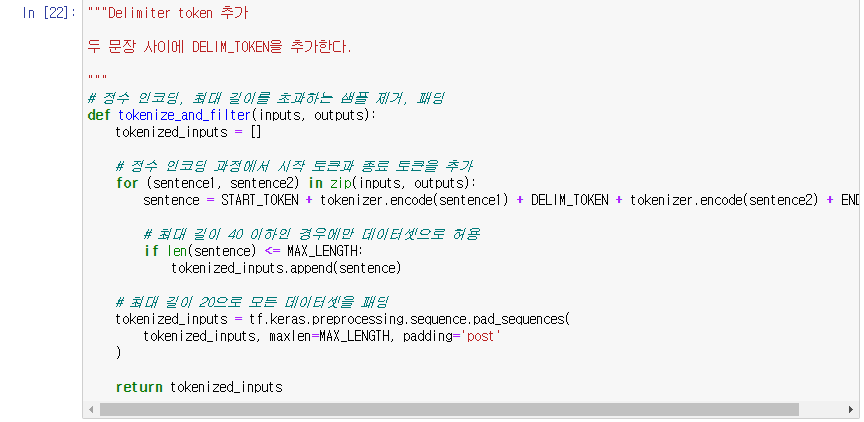  
#### input output 재구성
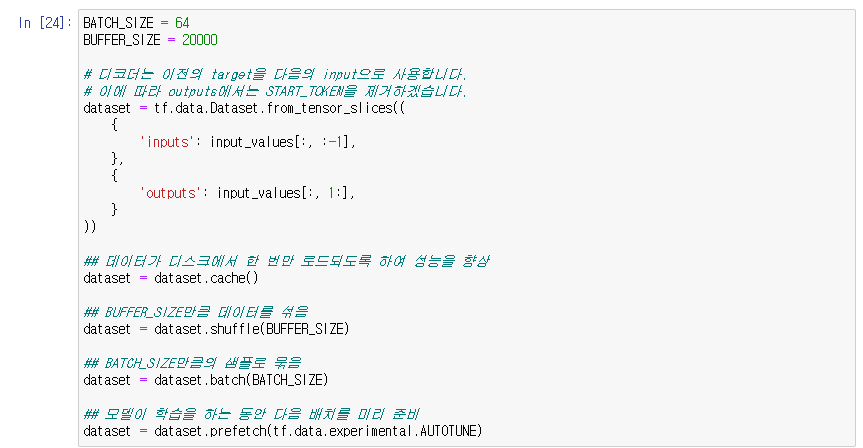  

In [22]:
"""Delimiter token 추가

두 문장 사이에 DELIM_TOKEN을 추가한다. 

"""
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs = []

    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence = START_TOKEN + tokenizer.encode(sentence1) + DELIM_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence) <= MAX_LENGTH:
            tokenized_inputs.append(sentence)

    # 최대 길이 20으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )

    return tokenized_inputs

In [23]:
input_values = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(input_values)))

단어장의 크기 : 8167
필터링 후의 질문 샘플 개수: 10960


#### 3. 데이터 셋 

In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': input_values[:, :-1],
    },
    {
        'outputs': input_values[:, 1:],
    }
))

## 데이터가 디스크에서 한 번만 로드되도록 하여 성능을 향상
dataset = dataset.cache()

## BUFFER_SIZE만큼 데이터를 섞음
dataset = dataset.shuffle(BUFFER_SIZE)

## BATCH_SIZE만큼의 샘플로 묶음
dataset = dataset.batch(BATCH_SIZE)

## 모델이 학습을 하는 동안 다음 배치를 미리 준비
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 정의 및 학습

## 4. GPT 모델을 정상적으로 구성하였다. (model.summary, model.fit 결과 캡쳐 첨부)

#### model.summary  
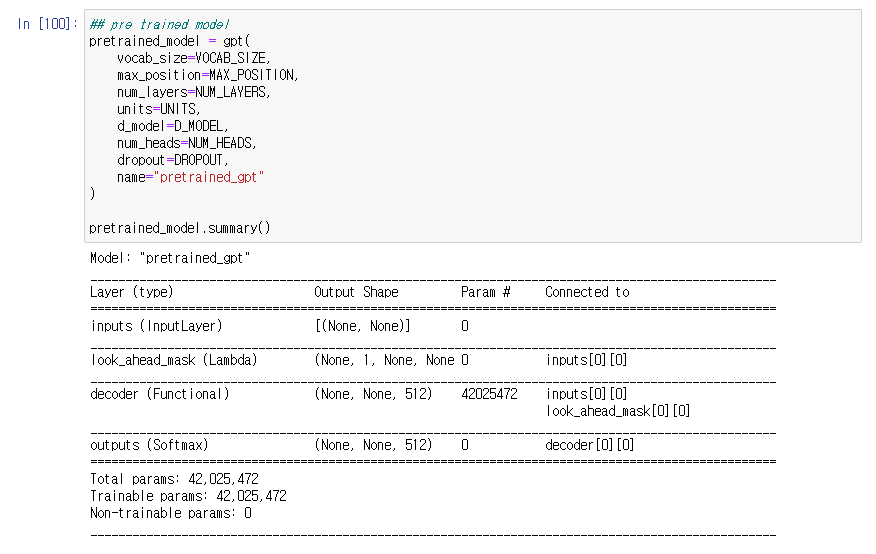     
#### model.fit
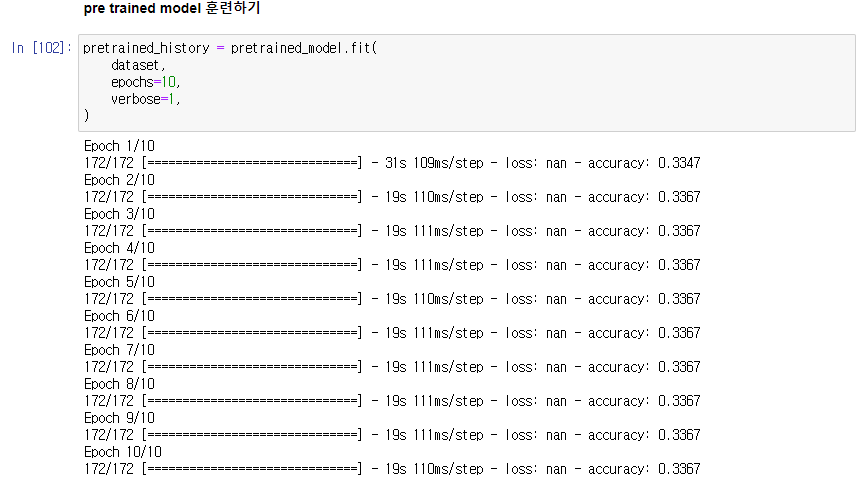   

#### 모델 생성

In [96]:
"""transformer -> gpt

gpt에서는 인코더를 사용하지 않으므로 관련된 코드들을 제거합니다. 

1. 인코더 input 제거  
2. 인코더 패딩을 위한 마스크 제거  
3. 인코더 제거  

디코더 아웃풋을 출력한다. pre train과 fine tuning을 구분하기 위해서 입니다. 

논문 식(2)의 마지막 수식을 추가합니다. softmax 사용

"""
def gpt(
    vocab_size,
    max_position,
    num_layers,
    units,
    d_model,
    num_heads,
    dropout,
    name="gpt"
   ):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs") 

    ## 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    ## 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
        )(inputs)

    ## 디코더
    outputs = decoder(
      vocab_size=vocab_size,
      max_position=max_position,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs,look_ahead_mask])
    
    ## softmax outputs
    outputs = tf.keras.layers.Softmax(name="outputs")(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

#### 손실 함수 

In [97]:
def loss_function1(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

#### 커스텀 된 학습률(Learning rate)

In [98]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### pre-trained 모델 생성

In [99]:
tf.keras.backend.clear_session()

## 하이퍼파라미터
NUM_LAYERS = 12 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 2048 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.15 # 드롭아웃의 비율
MAX_POSITION = 30

In [100]:
## pre trained model
pretrained_model = gpt(    
    vocab_size=VOCAB_SIZE,
    max_position=MAX_POSITION, 
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT, 
    name="pretrained_gpt"
)

pretrained_model.summary()

Model: "pretrained_gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 512)    42025472    inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Softmax)               (None, None, 512)    0           decoder[0][0]       

#### pre trained model 모델 컴파일

In [101]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

pretrained_model.compile(optimizer=optimizer, loss=loss_function1, metrics=[accuracy])

#### pre trained model 훈련하기

In [102]:
pretrained_history = pretrained_model.fit(
    dataset, 
    epochs=10, 
    verbose=1, 
)

Epoch 1/10
172/172 [==============================] - 31s 109ms/step - loss: nan - accuracy: 0.3347
Epoch 2/10
172/172 [==============================] - 19s 110ms/step - loss: nan - accuracy: 0.3367
Epoch 3/10
172/172 [==============================] - 19s 111ms/step - loss: nan - accuracy: 0.3367
Epoch 4/10
172/172 [==============================] - 19s 111ms/step - loss: nan - accuracy: 0.3367
Epoch 5/10
172/172 [==============================] - 19s 110ms/step - loss: nan - accuracy: 0.3367
Epoch 6/10
172/172 [==============================] - 19s 111ms/step - loss: nan - accuracy: 0.3367
Epoch 7/10
172/172 [==============================] - 19s 111ms/step - loss: nan - accuracy: 0.3367
Epoch 8/10
172/172 [==============================] - 19s 111ms/step - loss: nan - accuracy: 0.3367
Epoch 9/10
172/172 [==============================] - 19s 111ms/step - loss: nan - accuracy: 0.3367
Epoch 10/10
172/172 [==============================] - 19s 110ms/step - loss: nan - accuracy: 0.3367

#### fine tuning 모델 생성

In [ ]:
## fine tuning model
def fine_tune(pretrained_model):
    # 사전 훈련된 모델의 가중치 동결 (필요에 따라)
    pretrained_model.trainable = True  # 모델 가중치 고정 (선택사항)

    # 사전 훈련된 모델 위에 새로운 Linear Layer를 쌓음
    inputs = pretrained_model.input
    x = pretrained_model.output
    outputs = tf.keras.layers.Dense(units=VOCAB_SIZE, name="outputs")(x)  

    return tf.keras.Model(inputs=inputs, outputs=outputs)

finetuning_model = fine_tune(pretrained_model)
finetuning_model.summary()

## Step 5. 모델 평가하기

## 5. 입력에 따른 출력이 생성되었다. 
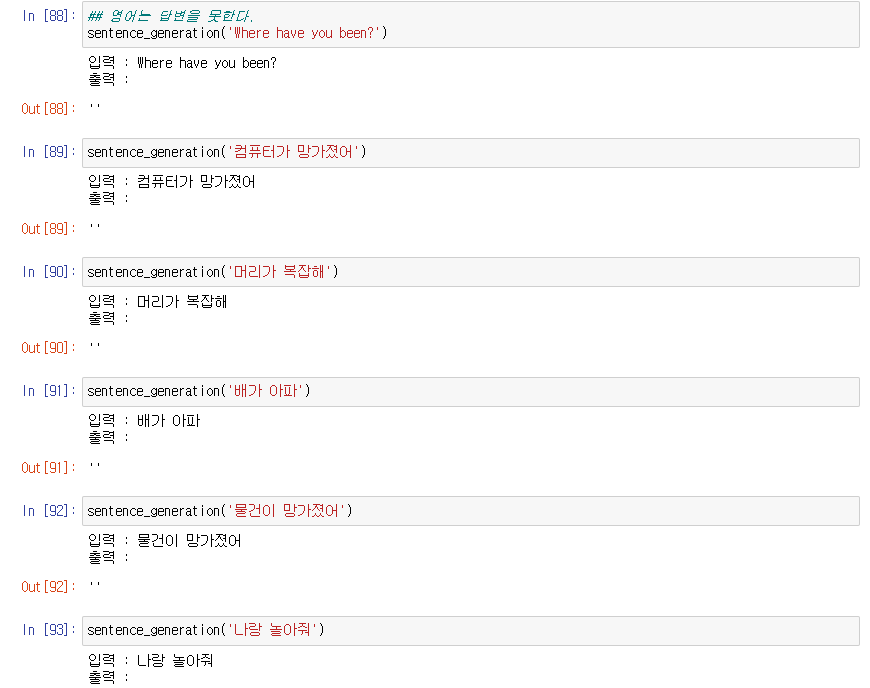  

In [103]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    ## 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    ## ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    ## 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    ## 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    ## 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        ## 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = pretrained_model(inputs=[output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        ## 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        ## 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        ## 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        ## 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [104]:
def sentence_generation(sentence):
    ## 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    ## 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [105]:
## 영어는 답변을 못한다. 
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : 


''

In [106]:
sentence_generation('컴퓨터가 망가졌어')

입력 : 컴퓨터가 망가졌어
출력 : 


''

In [107]:
sentence_generation('머리가 복잡해')

입력 : 머리가 복잡해
출력 : 


''

In [108]:
sentence_generation('배가 아파')

입력 : 배가 아파
출력 : 


''

In [109]:
sentence_generation('물건이 망가졌어')

입력 : 물건이 망가졌어
출력 : 


''

In [110]:
sentence_generation('나랑 놀아줘')

입력 : 나랑 놀아줘
출력 : 


''

In [111]:
sentence_generation('컴퓨터가 망가졌어')

입력 : 컴퓨터가 망가졌어
출력 : 


''